# Multi-channel, bidirectional optogenetics

Cleo supports the simultaneous use of multiple {class}`~cleo.light.Light` devices, multiple channels per device, and multiple opsins per neuron group.
Here' we'll see how to use all these features.

In [ ]:
# boilerplate
%load_ext autoreload
%autoreload 2
import brian2.only as b2
from brian2 import np, ms, mV, nmeter, mm, mm2, nA, pA, mwatt
import matplotlib.pyplot as plt

import cleo
from cleo import *

cleo.utilities.style_plots_for_docs()

# numpy faster than cython for lightweight example
b2.prefs.codegen.target = "numpy"
# for reproducibility
np.random.seed(1866)

# colors
c = {
    "main": "#C500CC",
    "473nm": "#72b5f2",
    "590nm": (1, 0.875, 0),
}

## Network setup
We'll use excitatory and inhibitory populations of [exponential integrate-and-fire neurons](https://neuronaldynamics.epfl.ch/online/Ch5.S2.html).

In [ ]:
n = 500
ng = b2.NeuronGroup(
    n,
    """
    dv/dt = (
        -(v - E_L)
        + Delta_T*exp((v-theta)/Delta_T)
        + Rm*(I_exc + I_inh + I_bg + I_enphr)
    ) / tau_m + sigma*sqrt(2/tau_m)*xi: volt
    I_exc : amp
    I_inh : amp
    I_enphr : amp
    """,
    threshold="v > -10*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * b2.Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70 * mV,
        "sigma": 5 * mV,
        "I_bg": 60 * pA,
    },
)
ng.v = np.random.uniform(-70, -50, n) * mV

W = 1 * mV
p_S = 0.3
n_neighbors = 40
S_ee = b2.Synapses(ng, model="w: 1", on_pre="v_post+=W*w/sqrt(N)")
S_ee.connect(condition="abs(i-j)<=n_neighbors and i!=j")
S_ee.w = np.exp(np.random.randn(int(S_ee.N - 0))) * np.random.choice(
    [-1, 1], int(S_ee.N - 0)
)

spike_mon = b2.SpikeMonitor(ng)
# for visualizing currents
Imon = b2.StateMonitor(ng, ("I_exc", "I_inh", "I_enphr"), record=range(50))
net = b2.Network(ng, S_ee, spike_mon, Imon)
sim = cleo.CLSimulator(net)

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

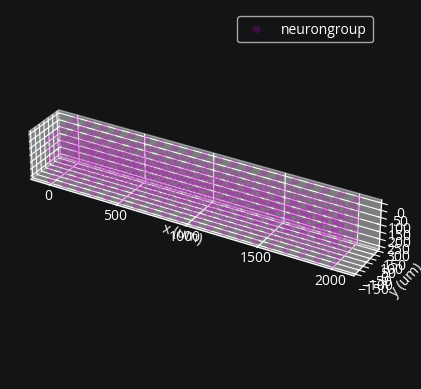

In [ ]:
xmax_mm = 2
cleo.coords.assign_coords_grid_rect_prism(
    ng, xlim=(0, xmax_mm), ylim=(-0.15, 0.15), zlim=(0, 0.3), shape=(20, 5, 5)
)
cleo.viz.plot(ng, colors=[c["main"]])

## Injecting a multi-channel `Light`

A {class}`~cleo.light.Light` device can have multiple channels; all the user needs is to specify the coordinates (and optionally direction) of each light source (channel).
A {class}`~cleo.light.LightModel` (e.g., that of an optical fiber) defines how light propagates from each source.

Here we inject 590 nm light for activating Vf-Chrimson.
Lacking a more rigorous quantification, we assume absorption and scattering coefficients of 590 nm light in the brain are roughly 0.8 times that of 470 nm light (see [Jacques 2013](https://iopscience.iop.org/article/10.1088/0031-9155/58/11/R37/meta) for some justification).

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

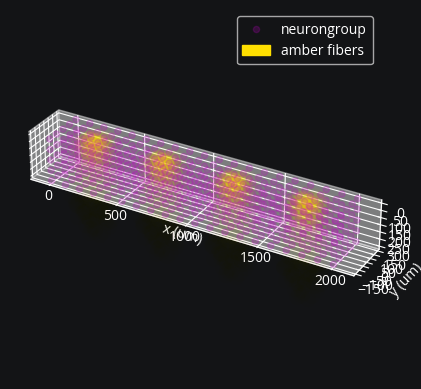

In [ ]:
n_fibers = 4
coords = np.zeros((n_fibers, 3))
end_space = 1 / (2 * n_fibers)
coords[:, 0] = np.linspace(end_space, 1 - end_space, n_fibers) * xmax_mm
coords[:, 1] = -0.025
amber_fibers = cleo.light.Light(
    name="amber fibers",
    coords=coords * mm,
    light_model=cleo.light.OpticFiber(K=0.125 * 0.8 / mm, S=7.37 * 0.8 / mm),
    wavelength=590 * nmeter,
)
sim.inject(amber_fibers, ng)
vfc = cleo.opto.vfchrimson_4s()
enphr3 = cleo.opto.enphr3_3s()
sim.inject(vfc, ng, Iopto_var_name="I_exc")
cleo.viz.plot(ng, colors=[c["main"]], sim=sim)

## Bidirectional control via a second opsin
Here we will demonstrate increasing and decreasing activity in the same experiment by injecting an inhibitory opsin with a minimally overlapping activation spectrum.
Alternatively, we could achieve bidirectional control with excitatory opsins on excitatory and inhibitory neurons.

We will use the anion channel GtACR2 which is maximally activated by 470 nm light.

Let's first visualize how the action spectra for the two opsins overlap:

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Action/excitation spectra'}, xlabel='λ (nm)', ylabel='ε'>)

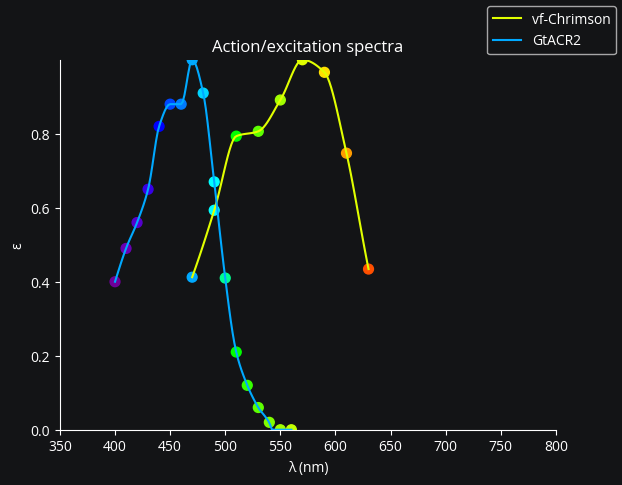

In [ ]:
gtacr2 = cleo.opto.gtacr2_4s()
cleo.light.plot_spectra(vfc, gtacr2)

We see that GtACR2 will be totally unaffected by amber (590 nm) light, while Vf-Chrimson will be slightly activated by blue (470 nm) light.

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

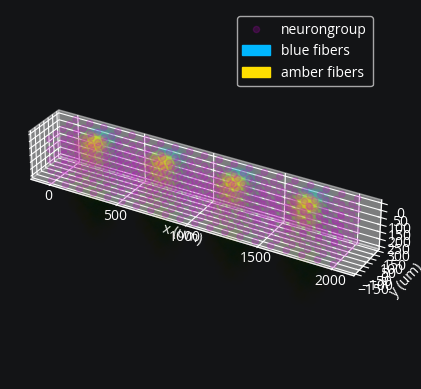

In [ ]:
coords[:, 1] = 0.025
blue_fibers = cleo.light.Light(
    name="blue fibers",
    coords=coords * mm,
    light_model=cleo.light.fiber473nm(),
)
sim.inject(blue_fibers, ng)
sim.inject(gtacr2, ng, Iopto_var_name="I_inh")
cleo.viz.plot(ng, colors=[c["main"]], sim=sim)

## Open-loop stimulation
We will now design a stimulus pattern to demonstrate bidirectional control segregated by channel.

In [ ]:
from cleo.ioproc import LatencyIOProcessor


class OpenLoopOpto(LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period=1 * ms)

    # since this is open-loop, we don't use state_dict
    def process(self, state_dict, t_samp):
        amplitude = 1 * mwatt / mm2
        time_offsets = np.array([0, -20, -40, -60])
        t = t_samp / ms + time_offsets
        amber = ((t >= 20) & (t < 40)) * amplitude
        blue = ((t >= 60) & (t < 63)) * amplitude

        # return output dict and time
        return ({"amber fibers": amber, "blue fibers": blue}, t_samp)


sim.set_io_processor(OpenLoopOpto())

CLSimulator(io_processor=OpenLoopOpto(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={BansalFourStateOpsin(name='GtACR2', save_history=True, on_pre='', spectrum=[(400, 0.4), (410, 0.49), (420, 0.56), (430, 0.65), (440, 0.82), (450, 0.88), (460, 0.88), (470, 1.0), (480, 0.91), (490, 0.67), (500, 0.41), (510, 0.21), (520, 0.12), (530, 0.06), (540, 0.02), (550, 0.0), (560, 0.0), (800, 1.4793867810610162e-06), (820, 1.8122488067997448e-06), (840, 2.0711414934854227e-06), (860, 2.404003519224151e-06), (880, 3.032742901175083e-06), (900, 3.2546509183342354e-06), (920, 3.2546509183342354e-06), (940, 3.6984669526525404e-06), (960, 3.3656049269138116e-06), (980, 2.4779728582772024e-06), (1000, 1.5163714505875414e-06), (1020, 7.766780600570334e-07), (1040, 4.4381603431830484e-07), (1060, 2.2190801715915242e-07), (1080, 7.39693390530508e-08), (1100, 0.0), (1120, 0.0)], extrapolate=False, required_vars=[('Iopto', amp), ('v', volt)], Gd1=17. * hertz, Gd2=10. * hertz, 

### Run simulation and plot results

In [ ]:
sim.reset()
sim.run(200 * ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.07s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


INFO       No numerical integration method specified for group 'syn_GtACR2_neurongroup', using method 'euler' (took 0.04s, trying other methods took 0.26s). [brian2.stateupdaters.base.method_choice]


INFO       No numerical integration method specified for group 'syn_vf_Chrimson_neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]


The {attr}`~cleo.light.Light.irradiance` attribute lets you access the light device's previously set values with units of mW/mm², while {attr}`~cleo.light.Light.irradiance_` strips the units.

[[],
 Text(0, 0.5, 'intensity per channel'),
 Text(0.5, 1.0, 'photostimulation'),
 Text(0.5, 0, 'time (ms)')]

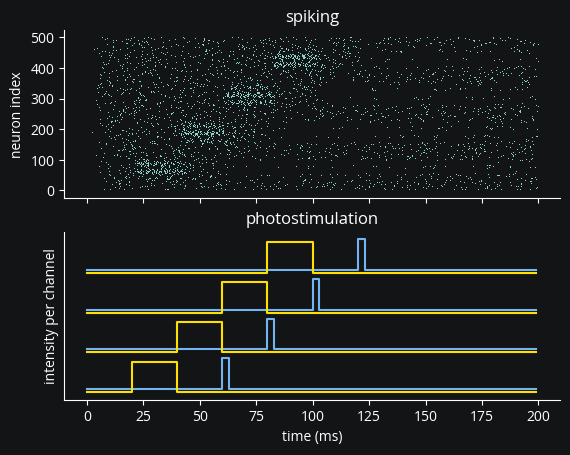

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(spike_mon.t / ms, spike_mon.i[:], ",")
ax1.set(ylabel="neuron index", title="spiking")

ax2.step(
    blue_fibers.t / ms,
    blue_fibers.irradiance_ + np.arange(n_fibers) * 1.3 + 0.1,
    c=c["473nm"],
    where="post",
)
ax2.step(
    amber_fibers.t / ms,
    amber_fibers.irradiance_ + np.arange(n_fibers) * 1.3,
    c=c["590nm"],
    where="post",
)
ax2.set(
    yticks=[],
    ylabel="intensity per channel",
    title="photostimulation",
    xlabel="time (ms)",
)

As you can see, Vf-Chrimson has fast dynamics, enabling high-frequency control.
GtACR2, on the other hand, continues acting long after the light is removed due to its slow deactivation kinetics.
We can confirm this by plotting the current from each of the opsins in the first segment of neurons:

[Text(0.5, 1.0, 'GtACR2 current'), Text(0, 0.5, '$I_{inh}$ (nA)')]

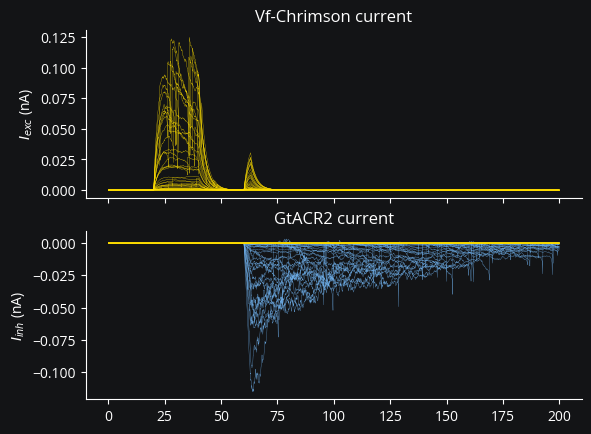

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(Imon.t / ms, Imon.I_exc.T / nA, lw=0.2, c=c["590nm"])
ax1.set(title="Vf-Chrimson current", ylabel="$I_{exc}$ (nA)")
ax2.plot(Imon.t / ms, Imon.I_inh.T / nA, lw=0.2, c=c["473nm"])
ax2.plot(Imon.t / ms, Imon.I_enphr.T / nA, lw=0.2, c=c["590nm"])
ax2.set(title="GtACR2 current", ylabel="$I_{inh}$ (nA)")

We can also confirm that blue light has a non-negligible effect on Vf-Chrimson.

## Conclusion
As a recap, in this tutorial we've seen how to:
* configure a multi-channel {class}`~cleo.light.Light` device,
* use more than one of them simultaneously, and
* inject multiple opsins of overlapping action spectra into the same network.